#Detection of hate text posted by Chadians on Facebook

##Import packages and Libraries

In [2]:
!python -m spacy download fr_core_news_md
#!!pip install scikit-multilearn

     |████████████████████████████████| 88.6 MB 11.6 MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-py3-none-any.whl size=90338488 sha256=7813bdc219d2ab32f2666cbd1638873c31d0f675313c03f9f8c0ee1e82e52c25
  Stored in directory: /tmp/pip-ephem-wheel-cache-7am828fn/wheels/2e/26/ff/ce93eb966e7176ebe81e6c98209582e13e108cdd2d6d636df0
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [3]:
import pandas as pd
import numpy as np
import re
import string
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import itertools
import fr_core_news_md
import logging
import nltk
#import skmultilearn
nltk.download('all', quiet=True)

True

In [4]:
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
####
from nltk import ngrams, bigrams
from nltk.stem import *
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize, WordNetLemmatizer
####
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
####
from spacy import displacy
from spacy.lang.fr.stop_words import STOP_WORDS as list_stop
from wordcloud import WordCloud, STOPWORDS
from random import randint, uniform
####
from time import time
from collections import defaultdict
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#Scikit-learn Libraries
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,recall_score,precision_score, ConfusionMatrixDisplay, f1_score, hamming_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
#from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

##Upload the datasets

In [6]:
#Load the train data
train_df=pd.read_csv('train_datasets.csv', encoding='latin')

#load the test data
test_df=pd.read_csv('test_datasets.csv', encoding ='latin')

#****************#
result_cbow=pd.read_csv('result_test.csv', encoding='latin')
result_skip=pd.read_csv('result_test.csv', encoding='latin')
result_countvec=pd.read_csv('result_test.csv', encoding='latin')
result_dov2vec=pd.read_csv('result_test.csv', encoding='latin')
result_fasttext=pd.read_csv('result_test.csv', encoding='latin')
train_df.head()

,id,query_type,message,Class,Label
0,8,Facebook:/<page-id>/posts,"?? Dr. Djiddi Ali Sougoudi : ""Pourquoi je regr...",neutral,4
1,19,Facebook:/<page-id>/posts,"Dr. Djiddi Ali Sougoudi : ""Pourquoi je regrett...",offensive,2
2,23,Facebook:/<post-id>/comments,Walay inal abouk zata,hate,1
3,38,Facebook:/<post-id>/comments,Da bineye hana wene wa,neutral,4
4,95,Facebook:/<post-id>/comments,Dehors guilital-adable,insult,3


In [7]:
test_df.head()

,id,comment
0,341,J'ai envie de dire à notre voisin que sa femme...
1,682,La viande de cheval est vendue à NDjamena don...
2,1835,Amine????????au pluriel aminerrrrrrrr wehhhh??...
3,2335,Amiss tchakkamna pini wa alyom moteur. Houmar ...
4,2336,Oui bonjour la famille Je ne jamais cru à Ndj...


In [8]:
#Rename Columns headers
train_df = train_df.rename(columns={"message": 'comment', "Label": 'target', 'Class':'categories'})

In [9]:
#Remove duplicate
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [10]:
#Nomber of comment per Label
train_df['target'].value_counts()

4    5006
2    1241
1     429
3     325
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


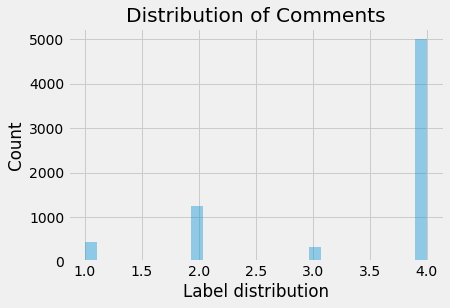

In [11]:
# Plot frequency of comments
fig = sns.distplot(train_df['target'], kde=False)
plt.xlabel("Label distribution")
plt.ylabel("Count")
plt.title("Distribution of Comments")
plt.show(fig)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


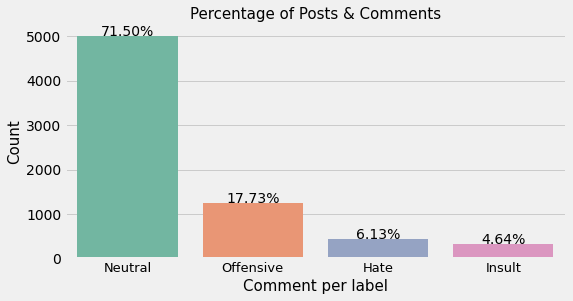

In [12]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(train_df['categories'], palette='Set2')

ax.set_title('Percentage of Posts & Comments',fontsize = 15)
ax.set_xlabel('Comment per label',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Neutral', 'Offensive','Hate', 'Insult'],fontsize = 13)

total = float(len(train_df)) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 
fig.savefig('statistic.png', bbox_inches='tight',transparent=True, dpi=1000)

##Data Preprocessing

###Cleaning Text

In [13]:
#Cleaning the data
def cleaning_text(train_df, col):
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'@[\S]+', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'&[\S]+?;', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'#', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'http[\S]+', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'[^\w\s]', r' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'\w*\d\w*', r' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'\s\s+', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'([a-zA-Z0-9_.+-]+)@[a-zA-Z0-9_.+-]+\.[a-zA-Z0-9_.+-]', '', str(x)))
    train_df[col]=train_df[col].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', x))
    return train_df[col]
train_df['comment']=cleaning_text(train_df, 'comment')
test_df['comment']=cleaning_text(test_df, 'comment')
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [14]:
train_df

,id,query_type,comment,categories,target
0,8,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi je regrette je...,neutral,4
1,19,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi je regrette je...,offensive,2
2,23,Facebook:/<post-id>/comments,walay inal abouk zata,hate,1
3,38,Facebook:/<post-id>/comments,da bineye hana wene wa,neutral,4
4,95,Facebook:/<post-id>/comments,dehors guilital adable,insult,3
...,...,...,...,...,...
6998,276748,Facebook:/<post-id>/comments,toi qui parle à sa place tu feras mieux ne jet...,neutral,4
6999,299676,Facebook:/<post-id>/comments,nous avons un grand doute que ceux qui chanten...,offensive,2
7000,299682,Facebook:/<post-id>/comments,les religieux ont enrôlés les enseignants dans...,neutral,4
7001,299726,Facebook:/<post-id>/comments,il est censé attendre et être emprisonné pour ...,offensive,2


In [15]:
test_df

,id,comment
0,341,j ai envie de dire à notre voisin que sa femme...
1,682,la viande de cheval est vendue à n djamena don...
2,1835,amine au pluriel aminerrrrrrrr wehhhh souvent ...
3,2335,amiss tchakkamna pini wa alyom moteur houmar g...
4,2336,oui bonjour la famille je ne jamais cru à ndja...
...,...,...
6995,286551,si ils ont étaient arrêter ce normal puisque l...
6996,287567,rectification les hommes troubleurs de bonnes ...
6997,287759,abdel ta pas l impression que t es entrain de ...
6998,289387,courage a vous l union fait la force c est de ...


###Remove Stopwords

In [16]:
#Remove stopword
stopwords.words("french")
stopwords_ls = list(set(stopwords.words("french")))
rem_stop = re.compile(r"\b(" + "|".join(stopwords_ls) + ")\\W", re.I)
#################
def removeStopWords(sentence):
    global rem_stop
    return rem_stop.sub("", sentence)
train_df['comment'] = train_df['comment'].apply(removeStopWords)
test_df['comment'] = test_df['comment'].apply(removeStopWords)

In [17]:
train_df

,id,query_type,comment,categories,target
0,8,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi regrette aucun...,neutral,4
1,19,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi regrette aucun...,offensive,2
2,23,Facebook:/<post-id>/comments,walay inal abouk zata,hate,1
3,38,Facebook:/<post-id>/comments,da bineye hana wene wa,neutral,4
4,95,Facebook:/<post-id>/comments,dehors guilital adable,insult,3
...,...,...,...,...,...
6998,276748,Facebook:/<post-id>/comments,parle place feras mieux jette première pierre ...,neutral,4
6999,299676,Facebook:/<post-id>/comments,grand doute ceux chantent tyran ans idriss deb...,offensive,2
7000,299682,Facebook:/<post-id>/comments,religieux enrôlés enseignants farine,neutral,4
7001,299726,Facebook:/<post-id>/comments,censé attendre être emprisonné être vrais comb...,offensive,2


In [18]:
test_df

,id,comment
0,341,envie dire voisin femme trompe quelqu autre fa...
1,682,viande cheval vendue djamena dont âne petit ch...
2,1835,amine pluriel aminerrrrrrrr wehhhh souvent dis...
3,2335,amiss tchakkamna pini wa alyom moteur houmar g...
4,2336,oui bonjour famille jamais cru ndjamena nadif ...
...,...,...
6995,286551,si arrêter normal puisque marche a interdit au...
6996,287567,rectification hommes troubleurs bonnes urs dan...
6997,287759,abdel impression entrain marcher terrain gliss...
6998,289387,courage a union fait force cette manière voulo...


###Lemmatization

In [19]:
nlp=fr_core_news_md.load(disable=['ner', 'parser'])
def lem_text(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    txt=[w.strip() for w in txt]
    if len(txt) > 1:
        return ' '.join(txt)

In [20]:
t = time()
train_txt = [lem_text(doc) for doc in nlp.pipe(train_df['comment'], batch_size=5000, n_threads=-1)]
test_txt = [lem_text(doc) for doc in nlp.pipe(test_df['comment'], batch_size=5000, n_threads=-1)]

train_df['comment_text'] = pd.DataFrame({'comment_text': train_txt})
test_df['comment_text'] = pd.DataFrame({'comment_text':test_txt}) 

train_df['comment_text'] = train_df['comment_text'].dropna().drop_duplicates()
test_df['comment_text']=test_df['comment_text'].dropna().drop_duplicates()

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.44 mins


###Check missing values

In [21]:
print("missing value of train set non-lemmatize:",train_df.comment.isnull().value_counts())
print("missing value of train set after lemmatize:", train_df.comment_text.isnull().value_counts())

missing value of train set non-lemmatize: False    7000
Name: comment, dtype: int64
missing value of train set after lemmatize: False    6857
True      143
Name: comment_text, dtype: int64


In [22]:
#Drop the rows have missing values on train file
#train_df = train_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
#train_df

In [23]:
print("missing value non-lemmatize",test_df.comment.isnull().value_counts())
print("missing value after lemmatize",test_df.comment_text.isnull().value_counts())

missing value non-lemmatize False    7000
Name: comment, dtype: int64
missing value after lemmatize False    6742
True      258
Name: comment_text, dtype: int64


In [24]:
#Drop missing values on test file
#test_df = test_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
#test_df

###Tokenization

In [25]:
#Words Tokenization
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    if set(tokens) not in list_stop: 
      return tokens
#train data
tokens=train_df['comment'].apply(lambda x: tokenize(str(x)))
train_df['tokens']=tokens
tokenslem=train_df['comment_text'].apply(lambda x: tokenize(str(x)))
train_df['tokens_lem']=tokenslem
#test data
tokens2=test_df['comment'].apply(lambda x: tokenize(str(x)))
test_df['tokens']=tokens2
tokens2lem=test_df['comment_text'].apply(lambda x: tokenize(str(x)))
test_df['tokens_lem']=tokens2lem

In [26]:
#Sentence Tokenization
def tokenize_s(text):
    tokens = nltk.sent_tokenize(text)
    if set(tokens) not in list_stop: 
      return tokens
#train data
tokens_s=train_df['comment'].apply(lambda x: tokenize_s(str(x)))
train_df['tokens_sent']=tokens_s
#test data
tokens2_s=test_df['comment'].apply(lambda x: tokenize_s(str(x)))
test_df['tokens_sent']=tokens2_s

In [27]:
train_df

,id,query_type,comment,categories,target,comment_text,tokens,tokens_lem,tokens_sent
0,8,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi regrette aucun...,neutral,4,dr djiddi ali sougoudi regrette regret respons...,"[dr, djiddi, ali, sougoudi, pourquoi, regrette...","[dr, djiddi, ali, sougoudi, regrette, regret, ...",[dr djiddi ali sougoudi pourquoi regrette aucu...
1,19,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi regrette aucun...,offensive,2,dr djiddi ali sougoudi regrette regret insulté...,"[dr, djiddi, ali, sougoudi, pourquoi, regrette...","[dr, djiddi, ali, sougoudi, regrette, regret, ...",[dr djiddi ali sougoudi pourquoi regrette aucu...
2,23,Facebook:/<post-id>/comments,walay inal abouk zata,hate,1,walay inal abouk zata,"[walay, inal, abouk, zata]","[walay, inal, abouk, zata]",[walay inal abouk zata]
3,38,Facebook:/<post-id>/comments,da bineye hana wene wa,neutral,4,bineye hana wene wa,"[da, bineye, hana, wene, wa]","[bineye, hana, wene, wa]",[da bineye hana wene wa]
4,95,Facebook:/<post-id>/comments,dehors guilital adable,insult,3,guilital adable,"[dehors, guilital, adable]","[guilital, adable]",[dehors guilital adable]
...,...,...,...,...,...,...,...,...,...
6998,276748,Facebook:/<post-id>/comments,parle place feras mieux jette première pierre ...,neutral,4,censé attendre emprisonner vrer combattre malh...,"[parle, place, feras, mieux, jette, première, ...","[censé, attendre, emprisonner, vrer, combattre...",[parle place feras mieux jette première pierre...
6999,299676,Facebook:/<post-id>/comments,grand doute ceux chantent tyran ans idriss deb...,offensive,2,nassak djarou machiftoum wa kane tidoro post o...,"[grand, doute, ceux, chantent, tyran, ans, idr...","[nassak, djarou, machiftoum, wa, kane, tidoro,...",[grand doute ceux chantent tyran ans idriss de...
7000,299682,Facebook:/<post-id>/comments,religieux enrôlés enseignants farine,neutral,4,NaN,"[religieux, enrôlés, enseignants, farine]",[nan],[religieux enrôlés enseignants farine]
7001,299726,Facebook:/<post-id>/comments,censé attendre être emprisonné être vrais comb...,offensive,2,NaN,"[censé, attendre, être, emprisonné, être, vrai...",[nan],[censé attendre être emprisonné être vrais com...


In [28]:
test_df

,id,comment,comment_text,tokens,tokens_lem,tokens_sent
0,341,envie dire voisin femme trompe quelqu autre fa...,envie voisin femme tromp quelqu compliquer,"[envie, dire, voisin, femme, trompe, quelqu, a...","[envie, voisin, femme, tromp, quelqu, compliquer]",[envie dire voisin femme trompe quelqu autre f...
1,682,viande cheval vendue djamena dont âne petit ch...,viande cheval vendu djamena âne petit cheval d...,"[viande, cheval, vendue, djamena, dont, âne, p...","[viande, cheval, vendu, djamena, âne, petit, c...",[viande cheval vendue djamena dont âne petit c...
2,1835,amine pluriel aminerrrrrrrr wehhhh souvent dis...,amine pluriel aminerrrrrrrr wehhhh dis tête,"[amine, pluriel, aminerrrrrrrr, wehhhh, souven...","[amine, pluriel, aminerrrrrrrr, wehhhh, dis, t...",[amine pluriel aminerrrrrrrr wehhhh souvent di...
3,2335,amiss tchakkamna pini wa alyom moteur houmar g...,amiss tchakkamna pini wa alyom moteur houmar g...,"[amiss, tchakkamna, pini, wa, alyom, moteur, h...","[amiss, tchakkamna, pini, wa, alyom, moteur, h...",[amiss tchakkamna pini wa alyom moteur houmar ...
4,2336,oui bonjour famille jamais cru ndjamena nadif ...,oui bonjour famill jamais cru ndjamena nadif n...,"[oui, bonjour, famille, jamais, cru, ndjamena,...","[oui, bonjour, famill, jamais, cru, ndjamena, ...",[oui bonjour famille jamais cru ndjamena nadif...
...,...,...,...,...,...,...
6995,286551,si arrêter normal puisque marche a interdit au...,arrêter normal marche interdire autorité eta f...,"[si, arrêter, normal, puisque, marche, a, inte...","[arrêter, normal, marche, interdire, autorité,...",[si arrêter normal puisque marche a interdit a...
6996,287567,rectification hommes troubleurs bonnes urs dan...,rectification homme troubleur bon ur danger so...,"[rectification, hommes, troubleurs, bonnes, ur...","[rectification, homme, troubleur, bon, ur, dan...",[rectification hommes troubleurs bonnes urs da...
6997,287759,abdel impression entrain marcher terrain gliss...,abdel impression entrain marcher terrain gliss...,"[abdel, impression, entrain, marcher, terrain,...","[abdel, impression, entrain, marcher, terrain,...",[abdel impression entrain marcher terrain glis...
6998,289387,courage a union fait force cette manière voulo...,courage union force manière vouloir voir tchad...,"[courage, a, union, fait, force, cette, manièr...","[courage, union, force, manière, vouloir, voir...",[courage a union fait force cette manière voul...


In [29]:
#list_tokens=tokens.to_list()
#list_tokens2=tokens2.to_list()
list_tokens=tokenslem.to_list()
list_tokens2=tokens2lem.to_list()
#list_tokens = train_df['comment'].apply(simple_preprocess)
#list_tokens2 = test_df['comment'].apply(simple_preprocess)

###Save the data after preprcoessing

In [30]:
#one hot encoding for label categories into multiclass
cat=pd.get_dummies(train_df['categories'])
train_df=pd.concat([train_df, cat],axis=1)
train_df.head()

,id,query_type,comment,categories,target,comment_text,tokens,tokens_lem,tokens_sent,hate,insult,neutral,offensive
0,8,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi regrette aucun...,neutral,4,dr djiddi ali sougoudi regrette regret respons...,"[dr, djiddi, ali, sougoudi, pourquoi, regrette...","[dr, djiddi, ali, sougoudi, regrette, regret, ...",[dr djiddi ali sougoudi pourquoi regrette aucu...,0,0,1,0
1,19,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi regrette aucun...,offensive,2,dr djiddi ali sougoudi regrette regret insulté...,"[dr, djiddi, ali, sougoudi, pourquoi, regrette...","[dr, djiddi, ali, sougoudi, regrette, regret, ...",[dr djiddi ali sougoudi pourquoi regrette aucu...,0,0,0,1
2,23,Facebook:/<post-id>/comments,walay inal abouk zata,hate,1,walay inal abouk zata,"[walay, inal, abouk, zata]","[walay, inal, abouk, zata]",[walay inal abouk zata],1,0,0,0
3,38,Facebook:/<post-id>/comments,da bineye hana wene wa,neutral,4,bineye hana wene wa,"[da, bineye, hana, wene, wa]","[bineye, hana, wene, wa]",[da bineye hana wene wa],0,0,1,0
4,95,Facebook:/<post-id>/comments,dehors guilital adable,insult,3,guilital adable,"[dehors, guilital, adable]","[guilital, adable]",[dehors guilital adable],0,1,0,0


In [31]:
test_df.to_csv('test_preprocessed.csv', index=True, encoding='latin')
train_df.to_csv('train_preprocessed.csv',index=False, encoding='latin')

###Most frequent words

In [32]:
#Most frequent words train 
word_freq = defaultdict(int)
for sent in tokenslem:
    for i in sent:
        word_freq[i] += 1
print("Most frequent words train:",len(word_freq))
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

Most frequent words train: 11353


['deby',
 'tchad',
 'midi',
 'mouton',
 'tchadien',
 'pays',
 'faire',
 'président',
 'vouloir',
 'masra']

In [33]:
#Most frequent words test
word_freq2 = defaultdict(int)
for sent in tokens2lem:
    for i in sent:
        word_freq2[i] += 1
print("Most frequent words test:",len(word_freq2))
sorted(word_freq2, key=word_freq2.get, reverse=True)[:10]

Most frequent words test: 13227


['tchad',
 'tchadien',
 'pays',
 'faire',
 'falloir',
 'deby',
 'vouloir',
 'politique',
 'peuple',
 'président']

###WordCloud for words per comment labelled

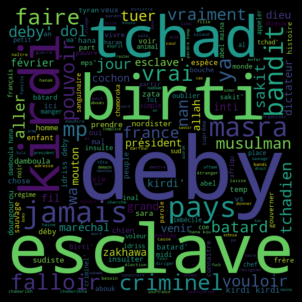

<Figure size 432x288 with 0 Axes>

In [34]:
#WordCloud for Hate comment
comments = train_df['comment_text'].loc[train_df['target']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black', stopwords = list_stop).generate(str(comments))
fig = plt.figure(
    figsize = (8, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('hate.png', bbox_inches='tight',transparent=True, dpi=1000)

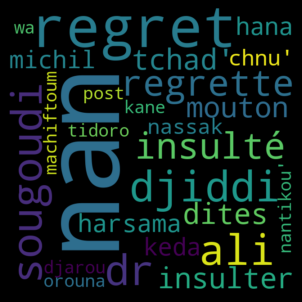

<Figure size 432x288 with 0 Axes>

In [35]:
#WordCloud for Offensive comment
comments = train_df['comment_text'].loc[train_df['target']==2].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black', stopwords = list_stop).generate(str(comments))
fig = plt.figure(
    figsize = (8, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('offensive.png', bbox_inches='tight',transparent=True, dpi=1000)

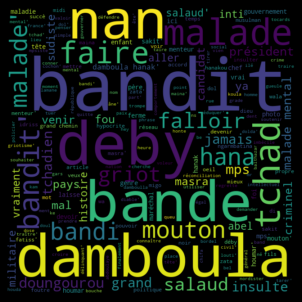

<Figure size 432x288 with 0 Axes>

In [36]:
#WordCloud for Insult comment
comments = train_df['comment_text'].loc[train_df['target']==3].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black', stopwords = list_stop).generate(str(comments))
fig = plt.figure(
    figsize = (8, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('insult.png', bbox_inches='tight',transparent=True, dpi=1000)

##Word Embedding Techniques

###Word2Vector Training model

In [37]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
#=======*****Train*****======
#Word2vec CBOW model train
cbow_model = Word2Vec(sg=0,min_count=2,window=5,size=300, workers=cores-1)
#Word2vec Skip-gram model train
skip_model = Word2Vec(sg=1,min_count=2,window=5,size=300, workers=cores-1)
#=======*****Test*****======
#Word2vec CBOW model test
ctest_model= Word2Vec(sg=0,min_count=2,window=5,size=300, workers=cores-1)
#Word2vec Skip-gram model test
stest_model = Word2Vec(sg=1,min_count=2,window=5,size=300, workers=cores-1)

In [38]:
#Build the vocabulary train
cbow_model.build_vocab(list_tokens, progress_per=10000)
skip_model.build_vocab(list_tokens, progress_per=10000)
#Build the vocabulary test
ctest_model.build_vocab(list_tokens2, progress_per=10000)
stest_model.build_vocab(list_tokens2, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.86 mins


In [39]:
#summarize vocabulary
corpus=list(cbow_model.wv.vocab)
#count rows
print(f"Total rows in Train corpus: {cbow_model.corpus_count}")
#total words
print(f"Total words in Train corpus: {cbow_model.corpus_total_words}")
#count rows
print(f"Total rows in Test corpus: {ctest_model.corpus_count}")
#total words
print(f"Total words in Test corpus: {ctest_model.corpus_total_words}")

Total rows in Train corpus: 7000
Total words in Train corpus: 56163
Total rows in Test corpus: 7000
Total words in Test corpus: 69370


In [40]:
#Train the model
cbow_model.train(list_tokens, total_examples=cbow_model.corpus_count, epochs=30, report_delay=1)
skip_model.train(list_tokens, total_examples=skip_model.corpus_count, epochs=30, report_delay=1)

#Test the model
ctest_model.train(list_tokens2, total_examples=ctest_model.corpus_count, epochs=30, report_delay=1)
stest_model.train(list_tokens2, total_examples=stest_model.corpus_count, epochs=30, report_delay=1)

print("Training a Gensim Word2Vec model complete")
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Training a Gensim Word2Vec model complete
Time to train the model: 1.55 mins


In [41]:
cbow_model.save('./cbow_train_data_hate_speech.model') 
stest_model.save('./skip_test_data_hate_speech.model')
#pickle.dump(cbow_model, open())

In [42]:
cbow_model.init_sims(replace=True)
skip_model.init_sims(replace=True)
ctest_model.init_sims(replace=True)
stest_model.init_sims(replace=True)

In [43]:
#most similarity
cbow_model.wv.most_similar(positive=["itno"])

[('idriss', 0.9793685674667358),
 ('déby', 0.9732178449630737),
 ('dictateur', 0.9650095105171204),
 ('hinda', 0.9623630046844482),
 ('régime', 0.9482518434524536),
 ('deby', 0.922101616859436),
 ('dégager', 0.9199224710464478),
 ('dictatorial', 0.9082934856414795),
 ('président', 0.9020468592643738),
 ('armée', 0.8810199499130249)]

In [44]:
skip_model.wv.most_similar(positive=["kouss"])

[('oumak', 0.9057427644729614),
 ('ra', 0.8965177536010742),
 ('ouma', 0.8928537964820862),
 ('oumah', 0.8803856372833252),
 ('traduction', 0.8640289306640625),
 ('kous', 0.8602611422538757),
 ('fatiss', 0.8485162258148193),
 ('ajoute', 0.8483148217201233),
 ('sabour', 0.8463236093521118),
 ('daboula', 0.8398563861846924)]

In [45]:
#value of particular word
cbow_model.wv.__getitem__('unir')

array([-4.86235786e-03, -2.31077280e-02, -5.23625053e-02, -5.22249192e-03,
        7.24981278e-02, -9.11112502e-02,  1.97523795e-02,  7.05545470e-02,
        8.35178327e-03, -1.93259381e-02, -8.03802013e-02, -4.16061059e-02,
       -8.44027568e-03,  2.90030558e-02,  5.49860671e-02, -3.46861631e-02,
       -1.47572190e-01, -2.13655587e-02, -3.77633213e-03,  1.08714756e-02,
       -1.73344053e-02,  1.42958090e-01, -8.16710442e-02, -5.70294857e-02,
        5.86733408e-02, -1.28418535e-01,  1.49456621e-03, -4.27519009e-02,
       -6.15709499e-02,  3.46280299e-02,  4.88055237e-02, -1.22735977e-01,
        4.24413122e-02,  9.62968096e-02,  3.16218399e-02,  3.01759392e-02,
        1.14034049e-01,  6.45006299e-02,  3.49642767e-04, -7.41133690e-02,
       -1.40736494e-02, -3.14723072e-03,  6.04046136e-03, -4.35733646e-02,
        4.35357587e-03,  6.39235452e-02, -8.60208496e-02,  2.66212430e-02,
        2.19175890e-02, -3.30412164e-02,  1.07666319e-02, -2.31195260e-02,
       -9.19290483e-02,  

In [46]:
#similarity between words
c=cbow_model.wv.similarity('hinda','déby')
print('CBOW:',c)
s=skip_model.wv.similarity('doungourou','mps')
print('Skip:',s)

CBOW: 0.95077187
Skip: 0.48128113


In [47]:
#Vector CBOW datasets
def cbow_wv(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += cbow_model[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec
######
def skip_wv(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += skip_model[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec
######
tr_vw= np.zeros((len(list_tokens), 300))
ctr_wv=tr_vw
str_wv = tr_vw
ts_wv = np.zeros((len(list_tokens2), 300))
cts_wv=ts_wv
sts_wv=ts_wv

#Train shape
for i in range(len(list_tokens)):
    ctr_wv[i,:] = cbow_wv(list_tokens[i], 300)
    str_wv[i,:] = skip_wv(list_tokens[i], 300)
ctrain_wv = pd.DataFrame(ctr_wv)
strain_wv=pd.DataFrame(str_wv)
#Test shape
for i in range(len(list_tokens2)):
    cts_wv[i,:] = cbow_wv(list_tokens2[i], 300)
    sts_wv[i,:] = skip_wv(list_tokens2[i], 300)
ctest_wv = pd.DataFrame(cts_wv)
stest_wv=pd.DataFrame(sts_wv)
####
print('Shape train sets word2vec:',ctrain_wv.shape, strain_wv.shape)
print('Shape test sets word2vec:',ctest_wv.shape, stest_wv.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Shape train sets word2vec: (7000, 300) (7000, 300)
Shape test sets word2vec: (7000, 300) (7000, 300)


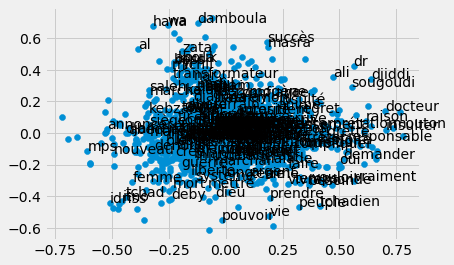

In [48]:
#visualization
X=cbow_model.wv.__getitem__(cbow_model.wv.vocab)
#create 2D model using PCA
pca_model=PCA(n_components=2)
result=pca_model.fit_transform(X)
#visualize
plt.scatter(result[:,0],result[:,1])
for i, word in enumerate(corpus[:200]):
  plt.annotate(s=word, xy=(result[i,0], result[i,1]))

plt.show()

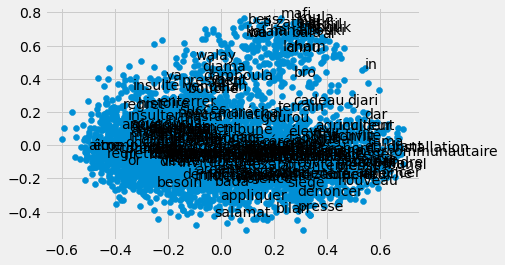

In [49]:
#visualization
X=skip_model.wv.__getitem__(skip_model.wv.vocab)
#create 2D model using PCA
pca_model=PCA(n_components=2)
result=pca_model.fit_transform(X)
#visualize
plt.scatter(result[:,0],result[:,1])
for i, word in enumerate(corpus[:200]):
  plt.annotate(s=word, xy=(result[i,0], result[i,1]))

plt.show()

###FastTest Training model

In [50]:
#FastText model
ftr_model=FastText(list_tokens,size=300, window=5, min_count=2)
fts_model=FastText(list_tokens2,size=300, window=5, min_count=2)
print("Training a Gensim FastText model complete")

Training a Gensim FastText model complete


In [51]:
#count rows
print(f"Total rows in Train corpus: {ftr_model.corpus_count}")
#total words
print(f"Total words in Train corpus: {ftr_model.corpus_total_words}")
#count rows
print(f"Total rows in Test corpus: {fts_model.corpus_count}")
#total words
print(f"Total words in Test corpus: {fts_model.corpus_total_words}")

Total rows in Train corpus: 7000
Total words in Train corpus: 56163
Total rows in Test corpus: 7000
Total words in Test corpus: 69370


In [52]:
ftr_model.most_similar(positive='itno')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('idriss', 0.9999737739562988),
 ('deby', 0.9999733567237854),
 ('maréchal', 0.9999732971191406),
 ('dictature', 0.9999727010726929),
 ('écouter', 0.9999722242355347),
 ('identique', 0.9999721050262451),
 ('présider', 0.9999720454216003),
 ('dicter', 0.9999720454216003),
 ('emporter', 0.9999719858169556),
 ('remporter', 0.9999719858169556)]

In [53]:
def word_vector(tokens, size):
     vec = np.zeros(size).reshape((1, size))
     count = 0.
     for word in tokens:
         try:
             vec += ftr_model[word].reshape((1, size))
             count += 1.
         except KeyError: # handling the case where the token is not in vocabulary
                         
             continue
     if count != 0:
         vec /= count
     return vec
fasttext_1 = np.zeros((len(list_tokens), 300))
fasttext_2 = np.zeros((len(list_tokens2), 300))

for i in range(len(list_tokens)):
     fasttext_1[i,:] = word_vector(list_tokens[i], 300)
for i in range(len(list_tokens2)):
     fasttext_2[i,:] = word_vector(list_tokens2[i], 300)
fasttext_train = pd.DataFrame(fasttext_1)
fasttext_test = pd.DataFrame(fasttext_2)
fasttext_train.shape, fasttext_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


((7000, 300), (7000, 300))

###Doc2vec Training model

In [54]:
#Tokenize the document
sp1=[TaggedDocument(doc,[i]) for i, doc in enumerate(list_tokens)]
sp2=[TaggedDocument(doc,[i]) for i, doc in enumerate(list_tokens2)]
#Define the model
d2vtr_model=Doc2Vec(vector_size=300, window=5, min_count=2, workers=8, epochs=40)
d2vts_model=Doc2Vec(vector_size=300, window=5, min_count=2, workers=8, epochs=40)
#Build vocabulary
d2vtr_model.build_vocab(sp1)
d2vts_model.build_vocab(sp2)
#Train the model
d2vtr_model.train(sp1, total_examples=d2vtr_model.corpus_count, epochs=d2vtr_model.epochs)
d2vts_model.train(sp2, total_examples=d2vts_model.corpus_count, epochs=d2vts_model.epochs)
print("Training a Gensim Doc2Vec model complete")

Training a Gensim Doc2Vec model complete


In [55]:
#generate vectors
d2vm=[d2vtr_model.infer_vector((list_tokens[i])) for i in range(0, len(list_tokens))]
#d2vm=[d2vtr_model.infer_vector((list_tokens[i].split(' '))) for i in range(0, len(list_tokens))]
doc2vec_train=np.array(d2vm)

##
d2vm1=[d2vts_model.infer_vector((list_tokens2[i])) for i in range(0, len(list_tokens2))]
doc2vec_test=np.array(d2vm1)

In [56]:
d2v_corpus=list(d2vtr_model.wv.vocab)
d2v_corpus2=list(d2vts_model.wv.vocab)
print(f'Total number of words:{d2v_corpus}')
#count rows
print(f"Total rows in corpus: {d2vtr_model.corpus_count}")
#total words
print(f"Total words in corpus: {d2vtr_model.corpus_total_words},{d2vts_model.corpus_total_words}")

Total number of words:['dr', 'djiddi', 'ali', 'sougoudi', 'regrette', 'regret', 'responsable', 'interprétation', 'tchad', 'insulté', 'insulter', 'mouton', 'dites', 'walay', 'inal', 'abouk', 'zata', 'hana', 'wa', 'mort', 'affrontement', 'salamat', 'nan', 'malade', 'mental', 'saleh', 'kebzabo', 'injustice', 'vivre', 'tchadien', 'yaki', 'tribune', 'restriction', 'efficace', 'être', 'michil', 'chnu', 'mafi', 'nar', 'koula', 'djari', 'idriss', 'deby', 'arrêter', 'faire', 'guerre', 'intercommunautaire', 'al', 'résolution', 'conflit', 'abéché', 'bouche', 'dirai', 'autorité', 'vouloir', 'poursuivre', 'justice', 'député', 'in', 'abouki', 'bala', 'radjil', 'ministère', 'jeuness', 'invité', 'succès', 'masra', 'cérémoni', 'installation', 'cnjt', 'continue', 'rêver', 'vendeur', 'or', 'bess', 'yi', 'aime', 'argent', 'interroger', 'temps', 'pouvoir', 'mettre', 'terre', 'enterrer', 'ya', 'djama', 'damboula', 'ti', 'bé', 'dizaine', 'blessé', 'violence', 'dar', 'tama', 'système', 'appliquer', 'bro', 'me

In [57]:
#most similarity
d2vtr_model.wv.most_similar("deby")

[('déby', 0.8925719261169434),
 ('pauvreté', 0.8772341012954712),
 ('itno', 0.8628275990486145),
 ('nation', 0.8519974946975708),
 ('assoiffé', 0.845778226852417),
 ('hinda', 0.8431969881057739),
 ('dictatorial', 0.8307784795761108),
 ('tyran', 0.8307026624679565),
 ('dictateur', 0.8272730112075806),
 ('dégager', 0.8208589553833008)]

In [58]:
d2vtr_model.most_similar(positive='kirdi')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sakite', 0.8920961618423462),
 ('sara', 0.8702681064605713),
 ('coule', 0.8425403833389282),
 ('yoskou', 0.8376163840293884),
 ('birti', 0.8298254013061523),
 ('sakit', 0.8291820287704468),
 ('olo', 0.8241767883300781),
 ('gouverner', 0.8080480098724365),
 ('habits', 0.77753084897995),
 ('yagot', 0.7774767279624939)]

###CountVectorizer

In [59]:
count1=CountVectorizer(analyzer='word')
count2=CountVectorizer(analyzer='word')
Xtrvec = count1.fit_transform(train_df['comment']).toarray()
Xtsvec=count2.fit_transform(test_df['comment']).toarray()

In [60]:
Xtrvec.shape, Xtsvec.shape

((7000, 13586), (7000, 15969))

In [61]:
count1.get_feature_names_out()

array(['___', '_il', '_pour', ..., 'être', 'êtres', 'êtés'], dtype=object)

In [62]:
count2.get_feature_names_out()

array(['___', '_kalam_', 'aacceptez', ..., 'île', 'ôte', 'ôter'],
      dtype=object)

##Splitting the data Train & Test

In [63]:
#Splitting the data to Train and Test
#cols_target=train_df[['hate', 'offensive','Insult', 'Neutral']]
#y_target=cols_target.idxmax(axis=1)
cols_target=['hate', 'insult', 'neutral', 'offensive']
y_target=train_df['target']
yh=train_df['hate']
yi=train_df['insult']
yo=train_df['offensive']
yn=train_df['neutral']

#Using Skip-gram model train
X_train1,X_test1, y_train1, y_test1 = train_test_split(strain_wv, y_target, test_size=0.3, random_state=42, stratify=y_target)
#Using CBOW model train
X_train0,X_test0, y_train0, y_test0 = train_test_split(ctrain_wv, y_target, test_size=0.3, random_state=42, stratify=y_target)
#Using Doc2vec model train
train_X,test_X, train_y, test_y = train_test_split(doc2vec_train, y_target, test_size=0.3, random_state=42, stratify=y_target)
#Using FastText model train & test
Xtrain,Xtest, ytrain, ytest = train_test_split(fasttext_train, y_target, test_size=0.3, random_state=42, stratify=y_target)
#Using countvectorizer
Xtr1,Xts1, ytr1, yts1 = train_test_split(Xtrvec,y_target, test_size=0.3, random_state=42, stratify=y_target)

In [64]:
#****Word2vec**********
# Using CBOW model train/test
X_ctrain=ctrain_wv
#y_ctrain=train_df['target']
X_ctest=ctest_wv
#y_ctest will be model.predict(X_ctest)
# Usinf Skip gram model train/test
X_strain=strain_wv
#y_strain=train_df['target']
X_stest=stest_wv
#y_stest will be model.predict(X_ctest)
# Doc2vec model
traind_X=doc2vec_train
testd_X=doc2vec_test
#FastText model
Xtrainf=fasttext_train
Xtestf=fasttext_test
#countvec
Xtrvec
Xtsvec

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##Machine Learning Classification

###Classification comparison

LR: 0.954 (0.000)
**********
SVM: 0.954 (0.000)
**********
Random Forest: 0.940 (0.000)
**********
KNN: 0.953 (0.000)
**********


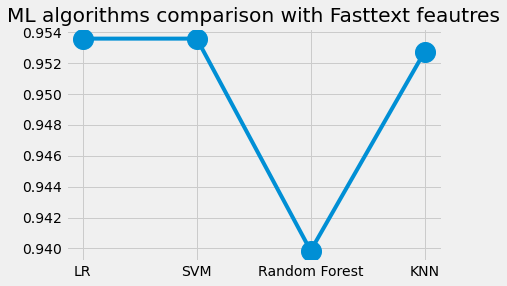

In [ ]:
#Classification comparison
models=[]
names=[]
results=[]
models.append(('LR', LogisticRegression(multi_class='ovr', max_iter=1000)))
models.append(('SVM', SVC(gamma='auto')))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
for name, model in models:
  cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
  #cv_results=cross_val_score(model, Xtestf, y_target, cv=cv, scoring='accuracy')
  model.fit(Xtrainf, yi)
  pred=model.predict(Xtestf)
  cv_results=accuracy_score(yi, pred)
  results.append(cv_results)
  names.append(name)
  print('%s: %.3f (%.3f)' % (name, cv_results.mean(), cv_results.std()))
  print('**********')

# Compare Algorithms
#plt.plot(results, labels=names)
plt.plot(names,results, marker = 'o', ms = 20)
plt.title('ML algorithms comparison with Fasttext feautres')
plt.savefig('Fasttext_compare_result.png', bbox_inches='tight',transparent=True, dpi=1000)

LR: 0.954 (0.0000)
************
Fitting 6 folds for each of 21 candidates, totalling 126 fits
SVM: 0.954 (0.0000)
************
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Random Forest: 0.940 (0.0000)
************
Fitting 6 folds for each of 12 candidates, totalling 72 fits
KNN: 0.954 (0.0000)
************


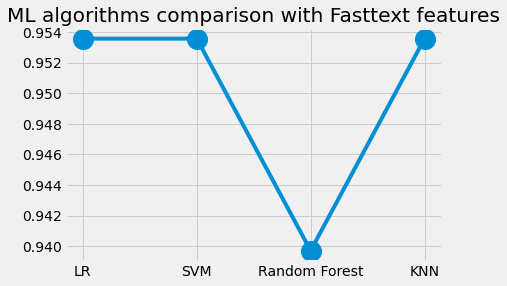

In [68]:
#Classification comparison tunned
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
#***logistic regression***
grid ={'solver':['lbfgs', 'liblinear', 'newton-cg'], 'penalty':['l2'],'C':[1000,100, 10]}
lr= GridSearchCV(estimator=LogisticRegression(multi_class='ovr', max_iter=1000), param_grid=grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0)

#*****SVM*****
param_grid = [{'C': [1, 10, 1000], 'kernel': ['linear']},{'C': [0.1, 1, 10, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}, {'C': [0.001, 0.1, 1, 10, 1000],'kernel':['sigmoid'],'gamma':[0.001,0.0001]}]
svm = GridSearchCV(estimator=SVC(gamma='auto'), param_grid=param_grid,verbose=2, cv=cv, n_jobs = -1, scoring ='accuracy')

#**** Random Forest****
param_grid = {'bootstrap': [True],'max_depth': [80],'max_features': [3], 'n_estimators': [1000], 'max_leaf_nodes':[500]}
rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=cv, n_jobs = -1, verbose = 2, scoring='accuracy')

#****KNN***
hypm = { 'n_neighbors' : [30, 40, 50, 60],'weights' : ['uniform'], 'metric' : ['minkowski'], 'leaf_size':[40, 50, 60], 'p':[2],'algorithm': ['auto']} 
knn=GridSearchCV(estimator=KNeighborsClassifier(), param_grid=hypm, cv=cv, n_jobs = -1, verbose = 2, scoring='accuracy')


models_tunned=[]
t_names=[]
t_results=[]
models_tunned.append(('LR', lr))
models_tunned.append(('SVM', svm))
models_tunned.append(('Random Forest', rf))
models_tunned.append(('KNN', knn))
for name, model in models_tunned:
  cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
  #t_cv_results=cross_val_score(model, Xtrain, ytrain, cv=cv, scoring='accuracy')

  model.fit(Xtrainf, yi)
  pred=model.predict(Xtestf)
  t_cv_results=accuracy_score(yi, pred)
  t_results.append(t_cv_results)
  t_names.append(name)
  print('%s: %.3f (%.4f)' % (name, t_cv_results.mean(), t_cv_results.std()))
  print('************')
# Compare Algorithms
#plt.boxplot(t_results, labels=t_names)
plt.plot(t_names, t_results, marker = 'o', ms = 20)
plt.title('ML algorithms comparison with Fasttext features')
plt.savefig('Fasttext_compare_tune.png', bbox_inches='tight',transparent=True, dpi=1000)

In [69]:
svm.best_params_ , lr.best_params_, rf.best_params_, knn.best_params_

({'C': 1, 'kernel': 'linear'},
 {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'},
 {'bootstrap': True,
  'max_depth': 80,
  'max_features': 3,
  'max_leaf_nodes': 500,
  'n_estimators': 1000},
 {'algorithm': 'auto',
  'leaf_size': 40,
  'metric': 'minkowski',
  'n_neighbors': 30,
  'p': 2,
  'weights': 'uniform'})

###Logistic Regression

In [ ]:
#Logistic classifier train sets split using word2vec, FastText, Doc2vec, CountVectorizer
mlr=LogisticRegression(multi_class='ovr', max_iter=5000)
#Apply Hyperparameter tuning
solvers = ['lbfgs','liblinear']
penalty = ['l2']
c_values = [100]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
lrc = GridSearchCV(estimator=mlr, param_grid=grid, n_jobs=1, cv=cv, scoring='accuracy',error_score=0)
lrs = GridSearchCV(estimator=mlr, param_grid=grid, n_jobs=1, cv=cv, scoring='accuracy',error_score=0)
lrd = GridSearchCV(estimator=mlr, param_grid=grid, n_jobs=1, cv=cv, scoring='accuracy',error_score=0)
lrf = GridSearchCV(estimator=mlr, param_grid=grid, n_jobs=1, cv=cv, scoring='accuracy',error_score=0)
lrcv = GridSearchCV(estimator=mlr, param_grid=grid, n_jobs=1, cv=cv, scoring='accuracy',error_score=0)

In [ ]:
#fit the model
lrc.fit(X_train0, y_train0) #CBOW
lrs.fit(X_train1, y_train1) #Skip
lrd.fit(train_X, train_y) #Doc2vec
lrf.fit(Xtrain, ytrain) #FastText
lrcv.fit(Xtr1, ytr1) #Countvec
#make prediction
lrc_pred=lrc.predict(X_test0)
lrs_pred=lrs.predict(X_test1)
lrd_pred=lrd.predict(test_X)
lrf_pred=lrf.predict(Xtest)
lrcv_pred=lrcv.predict(Xts1)
#Result without parameter tunning
print(f"Accuracy CBOW: {lrc.score(X_test0, y_test0)*100:.2f}%\nAccuracy CountVectorizer: {lrcv.score(Xts1, yts1)*100:.2f}%\nAccuracy Dov2Vec: {lrd.score(test_X, test_y)*100:.2f}%\nAccuracy Fasttext: {lrf.score(Xtest, ytest)*100:.2f}%\n")
#Classification report of the model with different features
print("CBOW:", classification_report(y_test0, lrc_pred),'\n')
print("CountVecorizer:", classification_report(yts1, lrcv_pred),'\n')
print("Doc2vec:", classification_report(test_y,lrd_pred),'\n')
print("FastText:", classification_report(ytest, lrf_pred),'\n')

In [ ]:
#Logistic classifier train & test sets using word2vec, FastText, Doc2vec
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_train & y_train
    lrc.fit(X_ctrain, y) #CBOW
    lrs.fit(X_strain, y) #Skip
    lrd.fit(traind_X, y) #Doc2vec
    lrf.fit(Xtrainf, y) #FastText

   # Generate predicted labels accuracy on Training set
    tr_cpred_X = lrc.predict(X_ctrain)
    tr_spred_X = lrs.predict(X_strain)
    tr_dpred_X = lrd.predict(traind_X)
    tr_fpred_X = lrf.predict(Xtrainf)
    print('CBOW + LR Train accuracy is {}'.format(round(accuracy_score(y, tr_cpred_X),2)),'\nSkip + LR Train accuracy is {}'.format(round(accuracy_score(y, tr_spred_X),2)),'\nDoc2vec + LR Train accuracy is {}'.format(round(accuracy_score(y, tr_dpred_X),2)),'\nFastText + LR train accuracy is {}\n'.format(round(accuracy_score(y, tr_fpred_X),2)))
   # Generate predicted labels accuracy on Test set
    ts_cpred_X = lrc.predict(X_ctest)
    ts_spred_X = lrs.predict(X_stest)
    ts_dpred_X = lrd.predict(testd_X)
    ts_fpred_X = lrf.predict(Xtestf)
    print('CBOW + LR Test accuracy is {}'.format(round(accuracy_score(y, ts_cpred_X),2)),'\nSkip + LR Test accuracy is {}'.format(round(accuracy_score(y, ts_spred_X),2)),'\nDoc2vec + LR Test accuracy is {}'.format(round(accuracy_score(y, ts_dpred_X),2)),'\nFastText + LR test accuracy is {}\n'.format(round(accuracy_score(y, ts_fpred_X),2)))
    # Generate predicted probabilities for labels
    test_y_probc = lrc.predict_proba(X_ctest)[:,1]
    test_y_probs = lrs.predict_proba(X_stest)[:,1]
    test_y_probd = lrd.predict_proba(testd_X)[:,1]
    test_y_probf = lrf.predict_proba(Xtestf)[:,1]
    
   #Save the result to file
    result_cbow[label] = test_y_probc
    result_skip[label] = test_y_probs
    result_dov2vec[label] = test_y_probd
    result_fasttext[label] = test_y_probf
    
result_cbow.to_csv('cbow_LR.csv',index=False, encoding='latin')
result_skip.to_csv('skip_LR.csv',index=False, encoding='latin')
result_dov2vec.to_csv('doc2vec_LR.csv',index=False, encoding='latin')
result_fasttext.to_csv('fasttext_LR.csv',index=False, encoding='latin')

... Processing hate
CBOW + LR Train accuracy is 0.94 
Skip + LR Train accuracy is 0.94 
Doc2vec + LR Train accuracy is 0.94 
FastText + LR train accuracy is 0.94

CBOW + LR Test accuracy is 0.93 
Skip Test + LR accuracy is 0.93 
Doc2vec + LR Test accuracy is 0.83 
FastText + LR test accuracy is 0.94

... Processing insult
CBOW + LR Train accuracy is 0.96 
Skip + LR Train accuracy is 0.96 
Doc2vec + LR Train accuracy is 0.95 
FastText + LR train accuracy is 0.95

CBOW + LR Test accuracy is 0.95 
Skip Test + LR accuracy is 0.95 
Doc2vec + LR Test accuracy is 0.89 
FastText + LR test accuracy is 0.95

... Processing neutral
CBOW + LR Train accuracy is 0.8 
Skip + LR Train accuracy is 0.8 
Doc2vec + LR Train accuracy is 0.79 
FastText + LR train accuracy is 0.72

CBOW + LR Test accuracy is 0.63 
Skip Test + LR accuracy is 0.63 
Doc2vec + LR Test accuracy is 0.57 
FastText + LR test accuracy is 0.71

... Processing offensive
CBOW + LR Train accuracy is 0.82 
Skip + LR Train accuracy is 0.82

####Confusion matrix

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y_test0, lrc_pred)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Actuels labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix for LR with CBOW features '); 
plt.savefig('lr_cbow_cfm.png', bbox_inches='tight',transparent=True, dpi=1000)

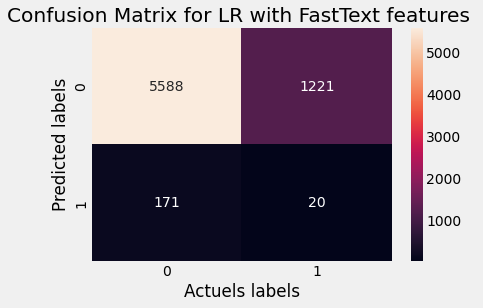

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y, ts_cpred_X)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Actuels labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix for LR with FastText features '); 
plt.savefig('lr_f_cfm.png', bbox_inches='tight',transparent=True, dpi=1000)

###Support Vector Machine

In [ ]:
#Support Vector Machine classifier train sets split using word2vec, FastText, Doc2vec
msvm=SVC(probability=True)
param_grid = [{'C': [1, 10], 'kernel': ['linear']},{'C': [1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}, {'C': [0.001, 0.1],'kernel':['sigmoid'],'gamma':[0.001,0.0001]}]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
csvm = GridSearchCV(estimator=msvm, param_grid=param_grid,verbose=2,cv=cv, n_jobs = 1, scoring ='accuracy')
svmcv = GridSearchCV(estimator=msvm, param_grid=param_grid,verbose=2, cv=cv, n_jobs = 1, scoring ='accuracy')
dsvm = GridSearchCV(estimator=msvm, param_grid=param_grid,verbose=2, cv=cv, n_jobs = 1, scoring ='accuracy')
fsvm = GridSearchCV(estimator=msvm, param_grid=param_grid,verbose=2, cv=cv, n_jobs = 1, scoring ='accuracy')
svms = GridSearchCV(estimator=msvm, param_grid=param_grid,verbose=2, cv=cv, n_jobs = 1, scoring ='accuracy')

In [ ]:
#fit the model
csvm.fit(X_train0, y_train0) #CBOW
svmcv.fit(Xtr1, ytr1) #Countvec
dsvm.fit(train_X, train_y) #Doc2vec
fsvm.fit(Xtrain, ytrain) #FastText
svms.fit(X_train1, y_train1) #Skip
#make prediction
csvm_pred=csvm.predict(X_test0)
svmcv_pred=svmcv.predict(Xts1)
dsvm_pred=dsvm.predict(test_X)
fsvm_pred=fsvm.predict(Xtest)
svms_pred=svms.predict(X_test1)
#Result without parameter tunning
print(f"Accuracy CBOW + SVM: {csvm.accuracy_score(y_test0, csvm_pred)*100:.2f}%") #\nAccuracy Skip + SVM: {svms.accuracy_score(y_test1, svms_pred)*100:.2f}%\nAccuracy CountVectorizer + SVM: {svmcv.accuracy_score(yts1, svmcv_pred)*100:.2f}%\nAccuracy Dov2Vec + SVM: {dsvm.accuracy_score(test_y, dsvm_pred)*100:.2f}%\nAccuracy Fasttext + SVM: {fsvm.accuracy_score(ytest, fsvm_pred)*100:.2f}%\n")

#Classification report of the model with different features
print("CBOW + SVM:", classification_report(y_test0, csvm_pred),'\n')
print("CountVectorizer + SVM:", classification_report(yts1, svmcv_pred),'\n')
print("Doc2vec + SVM:", classification_report(test_y, dsvm_pred),'\n')
print("FastText + SVM:", classification_report(ytest, fsvm_pred),'\n')

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END .................................C=1, kernel=linear; total time=   3.6s
[CV] END .................................C=1, kernel=linear; total time=   3.5s
[CV] END ................................C=10, kernel=linear; total time=   3.8s
[CV] END ................................C=10, kernel=linear; total time=   3.7s
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END .................................C=1, kernel=linear; total time= 9.7min
[CV] END .................................C=1, kernel=linear; total time= 9.8min
[CV] END ................................C=10, kernel=linear; total time= 9.5min
[CV] END ................................C=10, kernel=linear; total time= 9.5min


In [ ]:
print('precision:',precision_score(ytest, fsvm_pred, average='micro'))
print('recall:', recall_score(ytest, fsvm_pred, average='micro'))
print('f1_score:',f1_score(ytest, fsvm_pred, average='micro'))
print('accuracy:',accuracy_score(ytest, fsvm_pred, normalize=True))

In [ ]:
#Support Vector Machine classifier train sets split using word2vec, FastText, Doc2vec
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_train & y_train
    csvm.fit(X_ctrain, y) #CBOW
    svms.fit(X_strain, y) #Skip
    dsvm.fit(traind_X, y) #Doc2vec
    fsvm.fit(Xtrainf, y) #FastText
    # Generate predicted labels accuracy on train set
    tr_cpred_X = csvm.predict(X_ctrain)
    tr_spred_X = svms.predict(X_strain)
    tr_dpred_X = dsvm.predict(traind_X)
    tr_fpred_X = fsvm.predict(Xtrainf)
    print('CBOW + SVM train accuracy is {}'.format(round(accuracy_score(y, tr_cpred_X),2)),'\nSkip + SVM train accuracy is {}'.format(round(accuracy_score(y, tr_spred_X),2)),'\nDoc2vec + SVM Train accuracy is {}'.format(round(accuracy_score(y, tr_dpred_X),2)),'\nFastText + SVM train accuracy is {}\n'.format(round(accuracy_score(y, tr_fpred_X),2)))
    # Generate predicted labels accuracy on test set
    ts_cpred_X = csvm.predict(X_ctest)
    ts_spred_X = svms.predict(X_stest)
    ts_dpred_X = dsvm.predict(testd_X)
    ts_fpred_X = fsvm.predict(Xtestf)
    print('CBOW + SVM Test accuracy is {}'.format(round(accuracy_score(y, ts_cpred_X),2)),'\nSkip + SVM test accuracy is {}'.format(round(accuracy_score(y, ts_spred_X),2)),'\nDoc2vec + SVM Test accuracy is {}'.format(round(accuracy_score(y, ts_dpred_X),2)),'\nFastText + SVM test accuracy is {}\n'.format(round(accuracy_score(y, ts_fpred_X),2)))
    # Generate predicted probabilities for labels
    test_y_probc = csvm.predict_proba(X_ctest)[:,1]
    test_y_probs = svms.predict_proba(X_stest)[:,1]
    test_y_probd = dsvm.predict_proba(testd_X)[:,1]
    test_y_probf = fsvm.predict_proba(Xtestf)[:,1]
    
   #Save the result to file
    result_cbow[label] = test_y_probc
    result_skip[label] = test_y_probs
    result_dov2vec[label] = test_y_probd
    result_fasttext[label] = test_y_probf
result_cbow.to_csv('cbow_SVM.csv',index=False, encoding='latin')
result_skip.to_csv('skip_SVM.csv',index=False, encoding='latin')
result_dov2vec.to_csv('doc2vec_SVM.csv',index=False, encoding='latin')
result_fasttext.to_csv('fasttext_SVM.csv',index=False, encoding='latin')

In [ ]:
csvm.best_estimator_.get_params

####Confusion matrix

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y_test0, csvm_pred)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for SVM with CBOW features '); 
plt.savefig('svm_cbow_cfm.png', bbox_inches='tight',transparent=True, dpi=1000)

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y, y_fpred_X)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for SVM with FastText features '); 
plt.savefig('svm_f_cfm.png', bbox_inches='tight',transparent=True, dpi=1000)

###Random Forest

In [ ]:
#Random Forest classifier train sets split using word2vec, FastText, Doc2vec
mrf=RandomForestClassifier()
param_grid = {'bootstrap': [True],'max_depth': [80],'max_features': [3], 'n_estimators': [1000], 'max_leaf_nodes':[500]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
crf= GridSearchCV(estimator=mrf, param_grid=param_grid, cv=cv,n_jobs = -1, verbose = 2, scoring='accuracy')
frf= GridSearchCV(estimator=mrf, param_grid=param_grid, cv=cv,n_jobs = -1, verbose = 2, scoring='accuracy')
cvrf=GridSearchCV(estimator=mrf, param_grid=param_grid, cv=cv,n_jobs = -1, verbose = 2, scoring='accuracy')
drf=GridSearchCV(estimator=mrf, param_grid=param_grid, cv=cv,n_jobs = -1, verbose = 2, scoring='accuracy')
srf=GridSearchCV(estimator=mrf, param_grid=param_grid, cv=cv,n_jobs = -1, verbose = 2, scoring='accuracy')

In [ ]:
#fit the model
crf.fit(X_train0, y_train0) #CBOW
cvrf.fit(Xtr1, ytr1) #CountVec
drf.fit(train_X, train_y) #Doc2vec
frf.fit(Xtrain, ytrain) #FastText
srf.fit(X_train1, y_train1)
#make prediction
crf_pred=crf.predict(X_test0)
srf_pred=srf.predict(X_test1)
drf_pred=drf.predict(test_X)
frf_pred=frf.predict(Xtest)
cvrf_pred=cvrf.predict(Xts1)
print(f"Accuracy CBOW + RF: {crf.score(X_test0, y_test0)*100:.2f}%\nAccuracy Skip + RF: {srf.score(X_test1, y_test1)*100:.2f}%\nAccuracy CountVectorizer + RF: {cvrf.score(Xts1, yts1)*100:.2f}%\nAccuracy Dov2Vec + RF: {drf.score(test_X, test_y)*100:.2f}%\nAccuracy Fasttext + RF: {frf.score(Xtest, ytest)*100:.2f}%\n")

#Classification report of the model with different features
print("CBOW:", classification_report(y_test0, crf_pred),'\n')
print("CountVectorizer:", classification_report(yts1, cvrf_pred),'\n')
print("Doc2vec:", classification_report(test_y, drf_pred),'\n')
print("FastText:", classification_report(ytest, frf_pred),'\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Accuracy CBOW + RF: 74.10%
Accuracy Skip + RF: 74.00%
Accuracy CountVectorizer + RF: 71.52%
Accuracy Dov2Vec + RF: 73.38%
Accuracy Fasttext + RF: 71.19%

CBOW:               precision    recall  f1-score   support

           1       0.74      0.20      0.32       128
           2       0.59      0.05      0.10       372
           3       0.85      0.17      0.29        98
           4       0.74      0.99      0.85      1502

    accuracy                           0.74      2100
   macro avg       0.73      0.36      0.39      2100
weighted avg       0.72      0.74      0.66      2100
 

CountVectorizer:               precision    recall  f1-score   support

           1       0.00      0.00      0.00       128
           2       0.00      0.00      0.00       372
           3       0.00      0.00      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('precision:',precision_score(y_test1, srf_pred, average='micro'))
print('recall:', recall_score(y_test1, srf_pred, average='micro'))
print('f1_score:',f1_score(y_test1, srf_pred, average='micro'))
print('accuracy:',accuracy_score(y_test1, srf_pred, normalize=True))

precision: 0.74
recall: 0.74
f1_score: 0.74
accuracy: 0.74


In [ ]:
#Random Forest classifier train sets split using word2vec, FastText, Doc2vec

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_train & y_train
    crf.fit(X_ctrain, y) #CBOW
    srf.fit(X_strain, y) #Skip
    drf.fit(traind_X, y) #Doc2vec
    frf.fit(Xtrainf, y) #FastText
    # Generate predicted labels accuracy on test set
    tr_cpred_X = crf.predict(X_ctrain)
    tr_spred_X = srf.predict(X_strain)
    tr_dpred_X = drf.predict(traind_X)
    tr_fpred_X = frf.predict(Xtrainf)
    print('CBOW + RF train accuracy is {}'.format(round(accuracy_score(y, tr_cpred_X),2)),'\nSkip + RF train accuracy is {}'.format(round(accuracy_score(y, tr_spred_X),2)),'\nDoc2vec + RF train accuracy is {}'.format(round(accuracy_score(y, tr_dpred_X),2)),'\nFastText+ RF train accuracy is {}\n'.format(round(accuracy_score(y, tr_fpred_X),2)))
    # Generate predicted labels accuracy on test set
    ts_cpred_X = crf.predict(X_ctest)
    ts_spred_X = srf.predict(X_stest)
    ts_dpred_X = drf.predict(testd_X)
    ts_fpred_X = frf.predict(Xtestf)
    print('CBOW + RF test accuracy is {}'.format(round(accuracy_score(y, ts_cpred_X),2)),'\nSkip + RF test accuracy is {}'.format(round(accuracy_score(y, ts_spred_X),2)),'\nDoc2vec + RF test accuracy is {}'.format(round(accuracy_score(y, ts_dpred_X),2)),'\nFastText + RF test accuracy is {}\n'.format(round(accuracy_score(y, ts_fpred_X),2)))
    # Generate predicted probabilities for labels
    test_y_probc = crf.predict_proba(X_ctest)[:,1]
    test_y_probs = srf.predict_proba(X_stest)[:,1]
    test_y_probd = drf.predict_proba(testd_X)[:,1]
    test_y_probf = frf.predict_proba(Xtestf)[:,1]
    
   #Save the result to file
    result_cbow[label] = test_y_probc
    result_skip[label] = test_y_probs
    result_dov2vec[label] = test_y_probd
    result_fasttext[label] = test_y_probf
result_cbow.to_csv('cbow_RF.csv',index=False, encoding='latin')
result_skip.to_csv('skip_RF.csv',index=False, encoding='latin')
result_dov2vec.to_csv('doc2vec_RF.csv',index=False, encoding='latin')
result_fasttext.to_csv('fasttext_RF.csv',index=False, encoding='latin')

... Processing hate
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
CBOW + RF train accuracy is 1.0 
Skip + RF train accuracy is 1.0 
Doc2vec + RF train accuracy is 1.0 
FastText+ RF train accuracy is 1.0

CBOW + RF test accuracy is 0.93 
Skip + RF test accuracy is 0.93 
Doc2vec + RF test accuracy is 0.94 
FastText + RF test accuracy is 0.92

... Processing insult
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
CBOW + RF train accuracy is 1.0 
Skip + RF train accuracy is 1.0 
Doc2vec + RF train accuracy is 1.0 
FastText+ RF train accuracy is 1.0

CBOW + RF test accuracy is 0.94 
Skip + RF test accurac

####Confusion matrix

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y_test0, crf_pred)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for RF with CBOW features '); 
#ax.xaxis.set_ticklabels(['Neutral', 'Offensive','Hate', 'Insult']); ax.yaxis.set_ticklabels(['Insult', 'Hate', 'Offensive', 'Neutral']);
plt.savefig('svmf_cfmatrix.png', bbox_inches='tight',transparent=True, dpi=1000)

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y, y_fpred_X)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for RF with FastText features '); 
#ax.xaxis.set_ticklabels(['Neutral', 'Offensive','Hate', 'Insult']); ax.yaxis.set_ticklabels(['Insult', 'Hate', 'Offensive', 'Neutral']);
plt.savefig('svmf_cfmatrix.png', bbox_inches='tight',transparent=True, dpi=1000)

###K Nearest Neighbor

In [ ]:
mknn = KNeighborsClassifier()
hypm = { 'n_neighbors' : [60],
        'weights' : ['uniform'],
        'metric' : ['minkowski'], 
        'leaf_size':[60], 'p':[2],
        'algorithm': ['auto']} 
'''
hypm = { 'n_neighbors' : [5,6,7,8],
        'weights' : ['uniform','distance'],
        'metric' : ['minkowski','euclidean','manhattan'], 
        'leaf_size':[5, 6, 7], 'p':[1,2,3]}
'''
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
cknn = GridSearchCV(estimator=mknn, param_grid=hypm, cv=cv, n_jobs = -1, verbose = 2, scoring='accuracy')
sknn = GridSearchCV(estimator=mknn, param_grid=hypm, cv=cv, n_jobs = -1, verbose = 2, scoring='accuracy')
dknn = GridSearchCV(estimator=mknn, param_grid=hypm, cv=cv, n_jobs = -1, verbose = 2, scoring='accuracy')
fknn = GridSearchCV(estimator=mknn, param_grid=hypm, cv=cv,n_jobs = -1, verbose = 1, scoring='accuracy')
cvknn = GridSearchCV(estimator=mknn, param_grid=hypm, cv=cv,n_jobs = -1, verbose = 1, scoring='accuracy')

In [ ]:
#Labelled data: Fit/train the model using X_train & y_train
cknn.fit(X_train0, y_train0)  #X_train0,X_test0, y_train0, y_test0
sknn.fit(X_train1, y_train1)
dknn.fit(train_X,train_y)
fknn.fit(Xtrain, ytrain)   
cvknn.fit(Xtr1, ytr1)
#make prediction
y_cpred_X = cknn.predict(X_test0)
y_spred_X = sknn.predict(X_test1)
y_dpred_X = dknn.predict(test_X)
y_fpred_X = fknn.predict(Xtest)
y_cvpred_X = cvknn.predict(Xts1)

print('CBOW + KNN accuracy score: {}'.format(round(accuracy_score(y_test0, y_cpred_X),2)),'\nSkip + KNN accuracy score: {}'.format(round(accuracy_score(y_test1, y_spred_X),2)),'\nDoc2Vec + KNN accuracy score: {}'.format(round(accuracy_score(test_y, y_dpred_X),2)),'\nFastText + KNN accuracy score: {}\n'.format(round(accuracy_score(ytest, y_fpred_X),2)),'\nCountVectorizer + LR accuracy score: {}\n'.format(round(accuracy_score(yts1, y_cvpred_X),2)))
print("\nCBOW:", classification_report(y_test0, y_cpred_X))
print("\nCountVec:", classification_report(yts1, y_cvpred_X))
print("\nDoc2Vec:", classification_report(test_y, y_dpred_X))
print("FastText:", classification_report(ytest, y_fpred_X))


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CBOW + KNN accuracy score: 0.73 
Skip + KNN accuracy score: 0.73 
Doc2Vec + KNN accuracy score: 0.73 
FastText + KNN accuracy score: 0.72
 
CountVectorizer + LR accuracy score: 0.72


CBOW:               precision    recall  f1-score   support

           1       0.53      0.12      0.20       128
           2       0.37      0.13      0.19       372
           3       0.60      0.06      0.11        98
           4       0.75      0.97      0.85      1502

    accuracy                           0.73      2100
   macro avg       0.56      0.32      0.34      2100
weighted avg       0.67      0.73      0.66      2100


CountVec:               precision    recall  f1-score   support

           1       0.90      0.07      0.13       128
           2       0.38      0.02      0.03       372
           3       0.46      0.17      0.25        98
           4       0.73      0.99      0.84      1502

    accuracy                           0.72      2100
   macro avg       0.62      0.31     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y= train_df[label]
    # train the model using X_train & y_train
    cknn.fit(X_ctrain, y)
    sknn.fit(X_strain, y)
    dknn.fit(traind_X, y)
    fknn.fit(Xtrainf, y)
    # Generate predicted labels accuracy on Training set
    tr_cpred_X1 = cknn.predict(X_ctrain)
    tr_spred_X1 = sknn.predict(X_ctest)
    tr_dpred_X1 = dknn.predict(testd_X)
    tr_fpred_X1 = fknn.predict(Xtrainf)
    print('CBOW + KNN Train accuracy is {}'.format(round(accuracy_score(y, tr_cpred_X1),2)),'\nSkip + KNN Train accuracy is {}'.format(round(accuracy_score(y, tr_spred_X1),2)),'\nDoc2Vec + KNN Train accuracy is {}'.format(round(accuracy_score(y, tr_dpred_X1),2)),'\nFastText +KNN Train accuracy is {}\n'.format(round(accuracy_score(y, tr_fpred_X1),2)))
    # Generate predicted labels accuracy on Test set
    ts_cpred_X = cknn.predict(X_ctest)
    ts_spred_X= sknn.predict(X_stest)
    ts_dpred_X= dknn.predict(testd_X)
    ts_fpred_X = fknn.predict(Xtestf)
    print('CBOW Test set accuracy is {}'.format(round(accuracy_score(y, ts_cpred_X),2)),'\nSkip Test set accuracy is {}'.format(round(accuracy_score(y, ts_spred_X),2)),'\nDoc2Vec Test set accuracy is {}'.format(round(accuracy_score(y, ts_dpred_X),2)),'\nFastText Test set accuracy is {}\n'.format(round(accuracy_score(y, ts_fpred_X),2)))
    # Generate predicted probabilities for labels
    test_y_probc = cknn.predict_proba(X_ctest)[:,1]
    test_y_probs = sknn.predict_proba(X_stest)[:,1] 
    test_y_probd = dknn.predict_proba(testd_X)[:,1] 
    test_y_probf = fknn.predict_proba(Xtestf)[:,1] 
    #Save the result to file
    result_cbow[label] = test_y_probc
    result_skip[label] = test_y_probs
    result_dov2vec[label] = test_y_probd
    result_fasttext[label] = test_y_probf
result_cbow.to_csv('cbow_KNN.csv',index=False, encoding='latin')
result_skip.to_csv('skip_knn.csv', index=False, encoding='latin' )
result_dov2vec.to_csv('doc2vec_knn.csv', index=False, encoding='latin')
result_fasttext.to_csv('fasttext_KNN.csv',index=False, encoding='latin')
#Classification report of the model with different features
print("\nCBOW:", classification_report(y, tr_cpred_X1),'\n', classification_report(y, ts_cpred_X),'\n')
print("\nSkip:", classification_report(y, tr_spred_X1),'\n', classification_report(y, ts_spred_X),'\n')
print("\nDocv=2Vec:", classification_report(y, tr_dpred_X1),'\n', classification_report(y, ts_dpred_X),'\n')
print("FastText:", classification_report(y, tr_fpred_X1),'\n', classification_report(y, ts_fpred_X))

... Processing hate
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
CBOW + KNN Train accuracy is 0.94 
Skip + KNN Train accuracy is 0.94 
Doc2Vec + KNN Train accuracy is 0.94 
FastText +KNN Train accuracy is 0.94

CBOW Test set accuracy is 0.94 
Skip Test set accuracy is 0.94 
Doc2Vec Test set accuracy is 0.94 
FastText Test set accuracy is 0.94

... Processing insult
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
CBOW + KNN Train accuracy is 0.95 
Skip + KNN Train accuracy is 0.95 
Doc2Vec + KNN Train accuracy is 0.95 
FastText +KNN Train accuracy is 0.95

CBOW Test set accuracy is 0.95 
Skip Test s

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
#Print The value of best Hyperparameters
print('Best leaf_size CBOW:', cknn.best_estimator_.get_params()['leaf_size'],'\nBest leaf_size FastText:', fknn.best_estimator_.get_params()['leaf_size'])
print('CBOW Best p:', cknn.best_estimator_.get_params()['p'], '\nFastText Best p:', fknn.best_estimator_.get_params()['p'])
print('CBOW Best n_neighbors:', cknn.best_estimator_.get_params()['n_neighbors'], '\nFastText Best n_neighbors:', fknn.best_estimator_.get_params()['n_neighbors'])
print('Best score CBOW:',cknn.best_score_, '\nBest score FastText:', fknn.best_score_)
df1 = pd.DataFrame(cknn.cv_results_)[['params','mean_test_score','std_test_score']]
df2=pd.DataFrame(fknn.cv_results_)[['params','mean_test_score','std_test_score']]
df1.to_csv('cbow_knn_params.csv',index=False, encoding='latin')
df2.to_csv('ftt_knn_params.csv',index=False, encoding='latin')
df1

Best leaf_size CBOW: 60 
Best leaf_size FastText: 60
CBOW Best p: 2 
FastText Best p: 2
CBOW Best n_neighbors: 60 
FastText Best n_neighbors: 60
Best score CBOW: 0.8236428571428572 
Best score FastText: 0.8227142857142857


,params,mean_test_score,std_test_score
0,"{'algorithm': 'auto', 'leaf_size': 60, 'metric...",0.823643,0.001674


####Confusion Matrix

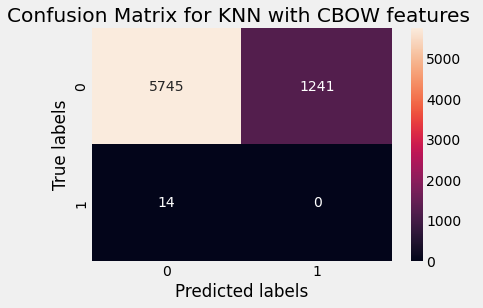

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y, ts_cpred_X, labels=cknn.classes_)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for KNN with CBOW features '); 
plt.savefig('knn_cbow_cfm.png', bbox_inches='tight',transparent=True, dpi=1000)

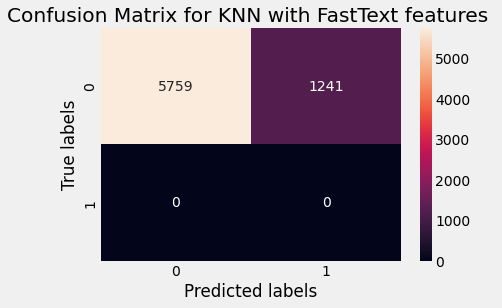

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y, ts_fpred_X, labels=fknn.classes_)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for KNN with FastText features '); 
plt.savefig('knn_f_cfm.png', bbox_inches='tight',transparent=True, dpi=1000)

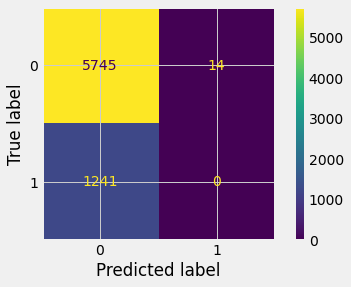

In [ ]:
cm=confusion_matrix(y, ts_cpred_X, labels=cknn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cknn.classes_)
disp.plot()
plt.show()

###Extreme Gradiant Boosting

In [ ]:
#Extreme Gradiant Boosting classifier train sets split using word2vec, FastText, Doc2vec
xgbc=XGBClassifier(use_label_encoder =False,objective ="binary:logistic")
param_dist = {'n_estimators': [150, 1000],
              'learning_rate': [0.01, 0.6],
              'subsample': [0.3, 0.9],
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': [0.5, 0.9],
              'min_child_weight': [1, 2, 3, 4]
             }
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
cxgbc = RandomizedSearchCV(xgbc, param_distributions = param_dist, n_iter = 25, scoring = 'accuracy', error_score = 0, verbose = 3, n_jobs = -1, cv=cv)
sxgbc = RandomizedSearchCV(xgbc, param_distributions = param_dist, n_iter = 25, scoring = 'accuracy', error_score = 0, verbose = 3, n_jobs = -1, cv=cv)
dxgbc = RandomizedSearchCV(xgbc, param_distributions = param_dist, n_iter = 25, scoring = 'accuracy', error_score = 0, verbose = 3, n_jobs = -1, cv=cv)
fxgbc = RandomizedSearchCV(xgbc, param_distributions = param_dist, n_iter = 25, scoring = 'accuracy', error_score = 0, verbose = 3, n_jobs = -1, cv=cv)
cvxgbc = RandomizedSearchCV(xgbc, param_distributions = param_dist, n_iter = 25, scoring = 'accuracy', error_score = 0, verbose = 3, n_jobs = -1, cv=cv)

In [ ]:
# Fit the model
cxgbc.fit(X_train0, y_train0) #CBOW
#sxgbc.fit(X_train1, y_train1) #Skip
#dxgbc.fit(train_X, train_y) #Doc2vec
#fxgbc.fit(Xtrain, ytrain) #FastText
#cvxgbc.fit(Xtr1, ytr1)
#make prediction
cxgbc_pred=cxgbc.predict(X_test0)
#sxgbc_pred=sxgbc.predict(X_test1)
#dxgbc_pred=dxgbc.predict(test_X)
#fxgbc_pred=fxgbc.predict(Xtest)
#cvxgbc_pred=cvxgbc.predit(Xts1)
#Result without parameter tunning
print(f"Accuracy CBOW: {cxgbc.score(X_test0, y_test0)*100:.2f}%")#\nAccuracy Skip: {sxgbc.score(X_test1, y_test1)*100:.2f}%\nAccuracy CountVectorizer: {cvxgbc.score(Xts1, yts1)*100:.2f}%\nAccuracy Dov2Vec: {dxgbc.score(test_X, test_y)*100:.2f}%\nAccuracy Fasttext: {fxgbc.score(Xtest, ytest)*100:.2f}%\n")

#Classification report of the model with different features
print("CBOW:", classification_report(y_test0,cxgbc_pred),'\n')
#print("CountVectorizer:", classification_report(yts1, cvxgbc_pred),'\n')
#print("Doc2vec:", classification_report(est_y, dxgbc_pred),'\n')
#print("FastText:", classification_report(ytest, fxgbc_pred),'\n')

In [ ]:
print('precision:',precision_score(test_y, dxgbc_pred, average='micro'))
print('recall:', recall_score(test_y, dxgbc_pred, average='micro'))
print('f1_score:',f1_score(test_y, dxgbc_pred, average='micro'))
print('accuracy:',accuracy_score(test_y, dxgbc_pred, normalize=True))

In [ ]:
#Extreme Gradiant Boosting classifier train sets split using word2vec, FastText, Doc2vec
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_train & y_train
    cxgbc.fit(X_ctrain, y) #CBOW
    sxgbc.fit(X_strain, y) #Skip
    dxgbc.fit(traind_X, y) #Doc2vec
    fxgbc.fit(Xtrainf, y) #FastText
    # Generate predicted labels accuracy on train set
    tr_cpred_X = cxgbc.predict(X_ctrain)
    tr_spred_X = sxgbc.predict(X_strain)
    tr_dpred_X = dxgbc.predict(traind_X)
    tr_fpred_X = fxgbc.predict(Xtrainf)
    print('CBOW + XGBC train accuracy is {}'.format(round(accuracy_score(y, tr_cpred_X),2)),'\nSkip + XGBC train accuracy is {}'.format(round(accuracy_score(y, tr_spred_X),2)),'\nDoc2vec + XGBC train accuracy is {}'.format(round(accuracy_score(y, tr_dpred_X),2)),'\nFastText + XGBC train accuracy is {}\n'.format(round(accuracy_score(y, tr_fpred_X),2)))
    # Generate predicted labels accuracy on test set
    ts_cpred_X = cxgbc.predict(X_ctest)
    ts_spred_X = sxgbc.predict(X_stest)
    ts_dpred_X = dxgbc.predict(testd_X)
    ts_fpred_X = fxgbc.predict(Xtestf)
    print('CBOW + XGBC test accuracy is {}'.format(round(accuracy_score(y, ts_cpred_X),2)),'\nSkip + XGBC test accuracy is {}'.format(round(accuracy_score(y, ts_spred_X),2)),'\nDoc2vec + XGBC test accuracy is {}'.format(round(accuracy_score(y, ts_dpred_X),2)),'\nFastText + XGBC test accuracy is {}\n'.format(round(accuracy_score(y, ts_fpred_X),2)))
    # Generate predicted probabilities for labels
    test_y_probc = cxgbc.predict_proba(X_ctest)[:,1]
    test_y_probs = sxgbc.predict_proba(X_stest)[:,1]
    test_y_probd = dxgbc.predict_proba(testd_X)[:,1]
    test_y_probf = fxgbc.predict_proba(Xtestf)[:,1]
    
   #Save the result to file
    result_cbow[label] = test_y_probc
    result_skip[label] = test_y_probs
    result_dov2vec[label] = test_y_probd
    result_fasttext[label] = test_y_probf
result_cbow.to_csv('cbow_XGBC.csv',index=False, encoding='latin')
result_skip.to_csv('skip_XGBC.csv',index=False, encoding='latin')
result_dov2vec.to_csv('doc2vec_XGBC.csv',index=False, encoding='latin')
result_fasttext.to_csv('fasttext_XGBC.csv',index=False, encoding='latin')

####Confusion Matrix

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y_test0, crf_pred)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for XGBC with CBOW features '); 
plt.savefig('xgbc_cbow_cfm.png', bbox_inches='tight',transparent=True, dpi=1000)

In [ ]:
ax= plt.subplot()
cm=confusion_matrix(y, y_fpred_X)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for XGBC with FastText features '); 
plt.savefig('xgbc_f_cfm.png', bbox_inches='tight',transparent=True, dpi=1000)